In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from GWForge.population.redshift import Redshift
import bilby
import numpy as np
import pylab as plt
import os
from glob import glob
import seaborn as sns
import pandas as pd
import dill
from tqdm import tqdm
from scipy.stats import ncx2
from pycbc.waveform import get_fd_waveform

In [2]:
MDhigh_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':2.53}
MDlow_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.54}
MD_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.9}

In [3]:
pop_num = 5

if pop_num == 4:
    pop_params = MDhigh_params
    MDmodel = 'MDhigh'
    z_str = f'z_{MDmodel}_zp_{pop_params["z_peak"]}'
elif pop_num == 5:
    pop_params = MDlow_params
    MDmodel = 'MDlow'
    z_str = f'z_{MDmodel}_zp_{pop_params["z_peak"]}'
else:
    pop_params = MD_params
    z_str = 'z_MD'

#netw = 'LHI_Asharp'
netw = 'CE4020ET123_CoBA10'

if 'Asharp' in netw:
    fref = 10
elif 'CE4020ET123' in netw:
    fref = 5
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
study_label = f'{netw}_SNR_{pop_num}_pop_PLP_spin_prec_fref_{fref}_{z_str}_zmax_10_lmrd_22_corrected_td'

In [4]:
#z_max = 6
z_max = 11
print(pop_params)
gwf_z = Redshift(redshift_model='MadauDickinson', 
                 local_merger_rate_density=22, 
                 maximum_redshift=z_max, 
                 gps_start_time=0, 
                 parameters=pop_params)
gwf_z_prob = gwf_z.coalescence_rate()

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:51

In [5]:
#z_grid = np.arange(0, z_max, 0.001)
z_grid = np.arange(0, z_max, 0.001)
p_z = bilby.core.prior.Interped(z_grid, gwf_z_prob(z_grid))

## Check the probability function against input population

/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/input_population/BBH/5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5


/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


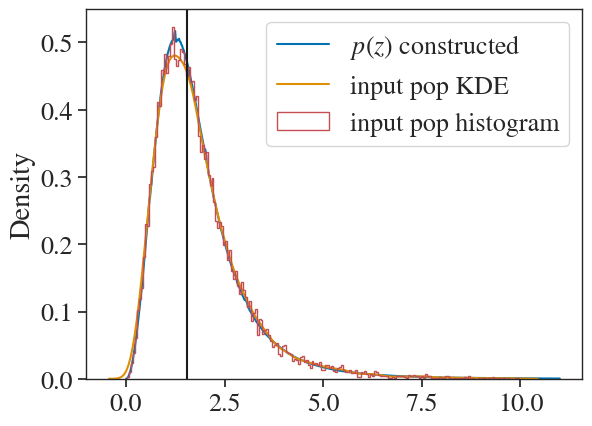

In [7]:
input_file = glob(os.path.join(project_dir, 'input_population', 'BBH', f'{pop_num}_pop*fref_{fref}*.h5'))[0]
print(input_file)
with h5py.File(input_file, 'r') as f:
#with h5py.File(glob(os.path.join(project_dir, 'input_population', 'BBH', '1_pop*.h5'))[0], 'r') as f:
    input_z = f['redshift'][:]
plt.plot(z_grid, p_z.probability_density(z_grid), label='$p(z)$ constructed')
sns.kdeplot(input_z, label='input pop KDE')
plt.hist(input_z, bins=200, histtype='step', density=True, label='input pop histogram', color='r');
plt.axvline(pop_params['z_peak'], c='k')
plt.legend()

## Load combined injection file

In [8]:
def decode_data(data):
    """
    Decodes byte strings or arrays of byte strings from HDF5.
    """
    if isinstance(data, bytes):
        return data.decode('utf-8')
    elif isinstance(data, np.ndarray) and data.dtype.kind in {'S', 'O'}:
        return [d.decode('utf-8') if isinstance(d, bytes) else d for d in data]
    else:
        return data

def load_from_h5_group(group):
    """
    Recursively loads data from an HDF5 group and reconstructs Python objects.
    """
    result = {}

    # Check if this group is an array-style list (all keys are numeric)
    keys = list(group.keys())
    if all(k.isdigit() for k in keys):
        # Treat it as a list, sorted by numeric key
        items = []
        for key in sorted(keys, key=lambda x: int(x)):
            val = group[key]
            if isinstance(val, h5py.Group):
                items.append(load_from_h5_group(val))
            else:
                items.append(decode_data(val[()]))
        return items

    # Otherwise treat as dict
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_from_h5_group(item)
        else:
            result[key] = decode_data(item[()])

    return result

def load_results_from_h5(filename):
    """
    Loads structured data from a universally saved HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        return load_from_h5_group(f)

In [9]:
combined_inj_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'combined_h5_files_select_params', 
                                 f'{study_label}_4M_points_XPHM.h5')
combined_inj_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/combined_h5_files_select_params/CE4020ET123_CoBA10_SNR_5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_corrected_td_4M_points_XPHM.h5'

In [10]:
injected_data = load_results_from_h5(combined_inj_file)
injected_data.keys()

dict_keys(['detected_mf_from_opt', 'total'])

In [11]:
injected_data['detected_mf_from_opt'] = pd.DataFrame(injected_data['detected_mf_from_opt'])

### Divide injections into mass bands

In [12]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [13]:
injected_data['detected_mf_from_opt'].keys()

Index(['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1',
       'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network',
       'distance', 'p_z', 'redshift', 'srcmtotal'],
      dtype='object')

In [14]:
mass_ranges = ['<40', '40-80', '>80']
injected_data['mass_select'] = {}
print('Total detected events =', len(injected_data['detected_mf_from_opt']), f"({len(injected_data['detected_mf_from_opt'])*100/len(injected_data['total']['redshift']):.2f} %)")
for m_range in mass_ranges:
    print(m_range)
    injected_data['mass_select'][m_range] = {'detected_mf_from_opt': injected_data['detected_mf_from_opt'][slice_mtotal_pop(injected_data['detected_mf_from_opt']['srcmtotal'], m_range)].reset_index().rename(columns={'index':'old_index'})}
    injected_data['mass_select'][m_range]['total'] = pd.DataFrame(injected_data['total'])[slice_mtotal_pop(injected_data['total']['srcmtotal'], m_range)]
    print('Total =', len(injected_data['mass_select'][m_range]['total']), f"({len(injected_data['mass_select'][m_range]['total'])*100/len(injected_data['total']['srcmtotal']):.2f}%)")
    print('Detected =', len(injected_data['mass_select'][m_range]['detected_mf_from_opt']), f"({len(injected_data['mass_select'][m_range]['detected_mf_from_opt'])*100/len(injected_data['mass_select'][m_range]['total']):.2f}%)" '\n')

Total detected events = 3868616 (96.72 %)
<40
Total = 3405816 (85.15%)
Detected = 3274989 (96.16%)

40-80
Total = 554444 (13.86%)
Detected = 553906 (99.90%)

>80
Total = 39732 (0.99%)
Detected = 39721 (99.97%)



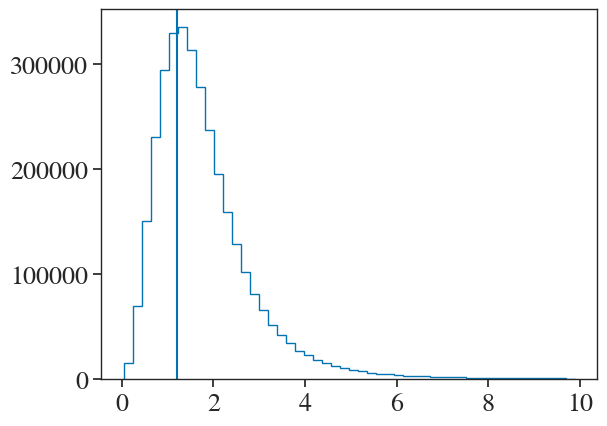

In [15]:
plt.hist(injected_data['mass_select']['<40']['detected_mf_from_opt']['redshift'], bins=50, histtype=u'step');
#plt.axvline(1.5)
#plt.axvline(2)
plt.axvline(1.2)

In [16]:
injected_data['mass_select']['<40']['detected_mf_from_opt']

,old_index,SNR_mf_from_opt_C1,SNR_mf_from_opt_CE20,SNR_mf_from_opt_E1,SNR_mf_from_opt_E2,SNR_mf_from_opt_E3,SNR_mf_from_opt_network,distance,p_z,redshift,srcmtotal
0,0,27.738931,10.988067,0.803270,2.435937,2.591410,30.057950,15685.527268,0.344074,1.974364,19.243756
1,1,26.732093,17.361665,9.825289,6.370289,9.963571,35.389572,14590.694520,0.379394,1.860922,23.640909
2,2,10.079553,3.711565,11.899933,11.668266,3.645939,20.159931,14292.173470,0.389157,1.829763,19.279080
3,3,33.011621,18.445187,15.961420,15.533453,18.580249,47.657872,11991.041171,0.460430,1.585848,21.029881
4,6,69.657069,41.005600,15.461156,10.425040,10.103440,83.566589,3731.656811,0.273691,0.613178,9.279205
...,...,...,...,...,...,...,...,...,...,...,...
3274984,3868608,21.253551,16.869035,10.097499,4.999600,8.956101,30.715550,12123.659069,0.456677,1.600102,15.186127
3274985,3868609,112.086929,76.450508,26.942624,23.795879,19.922937,141.764707,6562.403526,0.459559,0.972506,20.651586
3274986,3868610,26.901957,8.186959,12.025596,12.546538,16.071775,36.756960,11082.589898,0.482948,1.487470,16.167688
3274987,3868611,114.143941,53.823615,9.357245,23.899841,23.291120,130.870385,6104.905646,0.438407,0.917085,32.888929


## Write to file

#### MF from opt SNR detected population

In [17]:
z_dict_write_mf_from_opt = {}
for m_range in mass_ranges:
    z_dict_write_mf_from_opt[m_range] = {'redshift':np.array(injected_data['mass_select'][m_range]['detected_mf_from_opt']['redshift']), 
                                         'prior':np.array(injected_data['mass_select'][m_range]['detected_mf_from_opt']['p_z']),
                                         'total_generated':len(injected_data['mass_select'][m_range]['total']['redshift'])}

In [18]:
z_dict_write_mf_from_opt

{'<40': {'redshift': array([1.9743636 , 1.86092153, 1.8297629 , ..., 1.48746989, 0.91708465,
         2.07158997]),
  'prior': array([0.34407436, 0.37939395, 0.38915688, ..., 0.48294838, 0.43840724,
         0.31335917]),
  'total_generated': 3405816},
 '40-80': {'redshift': array([1.67652273, 1.58886239, 1.3204253 , ..., 2.185889  , 1.9483709 ,
         2.18664187]),
  'prior': array([0.43578057, 0.4596744 , 0.50474166, ..., 0.28072363, 0.35193788,
         0.28055314]),
  'total_generated': 554444},
 '>80': {'redshift': array([1.72324592, 1.71235049, 1.60936689, ..., 0.71863269, 0.61578242,
         1.60820841]),
  'prior': array([0.42171586, 0.42507666, 0.4540006 , ..., 0.33864492, 0.27522602,
         0.45430441]),
  'total_generated': 39732}}

In [19]:
def mass_range_names(range_name):
    return(range_name.replace('<', 'below_').replace('>', 'above_'))

In [20]:
for m_range in mass_ranges:
    num_points = z_dict_write_mf_from_opt[m_range]['total_generated']
    m_range_name = mass_range_names(m_range)
    write_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'mass_bands', 'XPHM')
    os.makedirs(write_dir, exist_ok=True)
    with open(os.path.join(write_dir,
                           f'{study_label}_detected_injs_mf_from_opt_SNR_{num_points}_points_{m_range_name}.pkl'), 
              'wb') as f:
        dill.dump(z_dict_write_mf_from_opt[m_range], f)